<a href="https://colab.research.google.com/github/kruth-s/FDS-Lab/blob/main/Expt_6_Prescriptive_Analytics_1RVU23CSE227.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import random
!pip install pulp
import pulp
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 58.5 MB/s eta 0:00:00


In [16]:
data = pd.read_csv("winequalityN.csv", sep=",")
data.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [15]:
print("Dataset Shape:", data.shape)
print("Columns:", list(data.columns))

Dataset Shape: (6497, 13)
Columns: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [18]:
data = data.dropna()
print("After dropping NAs:", data.shape)

After dropping NAs: (6463, 13)


In [20]:
# 1. OPTIMIZATION BASED

# Maximize quality proxy based on selected features
# features = ["alcohol", "sulphates", "citric acid"]

model = pulp.LpProblem("Maximize_Wine_Quality", pulp.LpMaximize)

features = ["alcohol", "sulphates", "citric acid"]
vars = {f: pulp.LpVariable(f, lowBound=data[f].min(), upBound=data[f].max()) for f in features}

numeric_data = data.select_dtypes(include=[np.number])
correlations = numeric_data.corr()["quality"][features].to_dict()

model += pulp.lpSum([correlations[f] * vars[f] for f in features])
model += vars["alcohol"] + vars["sulphates"] <= 20

model.solve()

print("\n--- Optimization Results ---")
for f in features:
    print(f, ":", pulp.value(vars[f]))
print("Estimated Quality Proxy:", pulp.value(model.objective))



--- Optimization Results ---
alcohol : 14.9
sulphates : 2.0
citric acid : 1.66
Estimated Quality Proxy: 6.8441739656278395


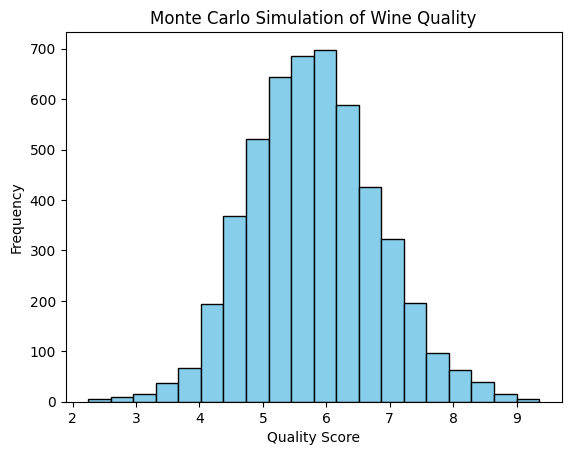


--- Simulation Results ---
Simulated Mean Quality: 5.80276819397075
Simulated Std Dev: 1.006161077197439


In [21]:
# 2. SIMULATION BASED

# Monte Carlo Simulation: simulate quality distribution given random variations in features

def simulate_quality(n=1000):
    results = []
    for _ in range(n):
        row = data.sample(1).iloc[0]
        noise = np.random.normal(0, 0.5)
        quality = row["quality"] + noise
        results.append(quality)
    return results

sim_results = simulate_quality(5000)
plt.hist(sim_results, bins=20, color="skyblue", edgecolor="black")
plt.title("Monte Carlo Simulation of Wine Quality")
plt.xlabel("Quality Score")
plt.ylabel("Frequency")
plt.show()

print("\n--- Simulation Results ---")
print("Simulated Mean Quality:", np.mean(sim_results))
print("Simulated Std Dev:", np.std(sim_results))


In [22]:
# 3. REINFORCEMENT LEARNING BASED

# Simplified Q-learning
# Goal: Choose alcohol level to maximize quality score

states = list(range(8, 15))  # alcohol percentage levels
actions = [-1, 0, 1]  # decrease, stay, increase
Q = {(s, a): 0 for s in states for a in actions}
alpha, gamma, epsilon = 0.1, 0.9, 0.2

def reward(alcohol_level):
    # reward = average quality for given alcohol
    subset = data[(data["alcohol"].round() == alcohol_level)]
    if subset.shape[0] > 0:
        return subset["quality"].mean()
    return 0

# Training
for _ in range(1000):
    state = random.choice(states)
    action = random.choice(actions) if random.random() < epsilon else max(actions, key=lambda a: Q[(state, a)])
    next_state = min(max(state + action, min(states)), max(states))
    r = reward(next_state)
    Q[(state, action)] += alpha * (r + gamma * max(Q[(next_state, a)] for a in actions) - Q[(state, action)])

# Best policy
policy = {s: max(actions, key=lambda a: Q[(s, a)]) for s in states}
print("\n--- Reinforcement Learning Results ---")
print("Optimal Policy (alcohol level decisions):")
print(policy)


--- Reinforcement Learning Results ---
Optimal Policy (alcohol level decisions):
{8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: 0, 14: -1}
